In [2]:
# required modules
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import geopandas as gpd
import plotly.express as px

# Initial Clustering

In [2]:
df_rest = pd.read_csv('../raw_data/raw_data_combined_v1.06.csv').drop(columns='original_index')
df_rest.head()

place_id  tripadvisor_id                    fsq_id  \
0  ChIJd6kh67ZkjEcRC1IQourQOyo       7159041.0  4de685281f6e9d90c7f5325c   
1  ChIJX68uubZkjEcRKKxpZ7OrgqU      13322506.0                       NaN   
2  ChIJPcYsG_BljEcR4kTFqBJJoK4       6720272.0                       NaN   
3  ChIJhb4e-Ep7jEcRY38kziIGZmE             NaN                       NaN   
4  ChIJV8uySFxljEcRn7XpIO3zZX0             NaN                       NaN   

                              name business_status  \
0          Restaurant La Tentation     OPERATIONAL   
1            Café Restaurant Palma     OPERATIONAL   
2                    Le Versailles     OPERATIONAL   
3                 Restaurant Divan     OPERATIONAL   
4  Restaurant Les Jardins du Rhône     OPERATIONAL   

                                               types  price_level  \
0  ['restaurant', 'point_of_interest', 'food', 'e...          2.0   
1  ['restaurant', 'point_of_interest', 'food', 'e...          NaN   
2  ['restaurant', 'point_of_interest', 'food', 'e...          NaN   
3  ['restaurant', 'food', 'point_of_interest', 'e...          2.0   
4  ['restaurant', 'food', 'point_of_interest', 'e...          NaN   

   ta_price_level  rating  user_ratings_total  ...   population_age_0_14   \
0             2.0     4.2               158.0  ...                   4967   
1             NaN     3.7               141.0  ...                   4967   
2             2.0     3.9                56.0  ...                   4967   
3             NaN     4.5               113.0  ...                   6055   
4             NaN     NaN                 NaN  ...                   4967   

    population_15_19    population_20_24    population_25_34   \
0                1547                1937                5163   
1                1547                1937                5163   
2                1547                1937                5163   
3                1956                2148                4721   
4                1547                1937                5163   

    population_35_44   population_45_54    population_54_64   population_65+   \
0                5549               4924                4290             5625   
1                5549               4924                4290             5625   
2                5549               4924                4290             5625   
3                5127               5017                3956             5342   
4                5549               4924                4290             5625   

   resident_per_km2   brut_income_annual_per_person   
0              16282                          109266  
1              16282                          109266  
2              16282                          109266  
3               7187                          123472  
4              16282                          109266  

[5 rows x 44 columns]

In [3]:
df_rest.columns

Index(['place_id', 'tripadvisor_id', 'fsq_id', 'name', 'business_status',
       'types', 'price_level', 'ta_price_level', 'rating',
       'user_ratings_total', 'ta_rating', 'ta_user_ratings_total',
       ' combined_rating ', 'geometry.location.lat', 'geometry.location.lng',
       'formatted_address', 'zip_code', 'city', 'international_phone_number',
       'website', 'google_category', 'ta_4sq_cuisine1', 'ta_4sq_cuisine2',
       'ta_4sq_cuisine3', 'ta_4sq_cuisine4', 'ta_4sq_cuisine5',
       'main_category_1', 'main_category_2', 'main_category_3',
       'main_category_4', 'combined_main_category', 'sub_category',
       ' neighboorhood_area_km2 ', '  resident_population_total ',
       ' population_age_0_14 ', ' population_15_19 ', ' population_20_24 ',
       ' population_25_34 ', ' population_35_44 ', ' population_45_54 ',
       ' population_54_64 ', ' population_65+ ', ' resident_per_km2 ',
       ' brut_income_annual_per_person '],
      dtype='object')

In [4]:
rest_grid_points = df_rest[['geometry.location.lat', 'geometry.location.lng']].to_numpy()
rest_grid_points

array([[46.205232 ,  6.1149446],
       [46.2049308,  6.1140212],
       [46.2057517,  6.1147635],
       ...,
       [46.1997726,  6.174561 ],
       [46.1996953,  6.175007 ],
       [46.2016903,  6.1746138]])

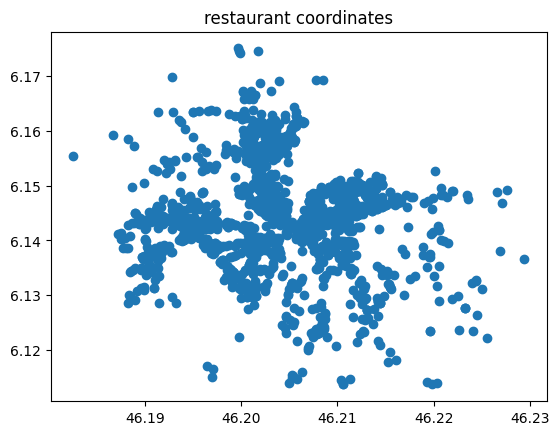

In [5]:
lat, lng = rest_grid_points[:,0], rest_grid_points[:,1]
plt.title('restaurant coordinates')
plt.scatter(lat, lng);

In [193]:
# let's start with a baseline of 4 arbitrary, just by looking at the graph
X = rest_grid_points
random_state = 42 #important to have reproducable kmeans algorithm

# Instanciate the model
km_base = KMeans(n_clusters=4, random_state=random_state)

# fit kmeans on grid_points
km_base.fit(X)

# make a prediction
y_pred_base = pd.Series(km_base.labels_)
y_pred_base

0       2
1       2
2       2
3       2
4       2
       ..
1608    0
1609    0
1610    0
1611    0
1612    0
Length: 1613, dtype: int32

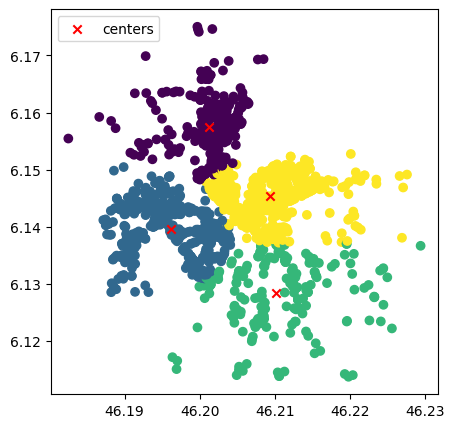

In [195]:
plt.figure(figsize=(5,5))
plt.scatter(X[:,0],X[:,1], c=y_pred_base)
plt.scatter(km_base.cluster_centers_[:,0], km_base.cluster_centers_[:,1], c='r', marker='x', label='centers')
plt.legend(loc='upper left')
plt.show()

## Find the optimal number of clusters

## Inertia Analysis

In [194]:
# Let's find the best K
# have a look at zip codes, this can be the arbitrary maximum number of clusters if we do not use any machine learning
df_rest['zip_code'].nunique()

16

In [122]:
wcss = [] #within-cluster sum of square
clusters = list(range(1, 17))
for cluster in clusters:
    intertia = KMeans(n_clusters=cluster, random_state=random_state).fit(X).inertia_
    wcss.append(intertia)

In [123]:
df_wcss = pd.DataFrame({'wcss':wcss}, index=clusters)
df_wcss

wcss
1   0.242895
2   0.152367
3   0.102784
4   0.064896
5   0.053450
6   0.043930
7   0.038192
8   0.033671
9   0.029794
10  0.027610
11  0.024494
12  0.022370
13  0.020419
14  0.019042
15  0.017543
16  0.016199

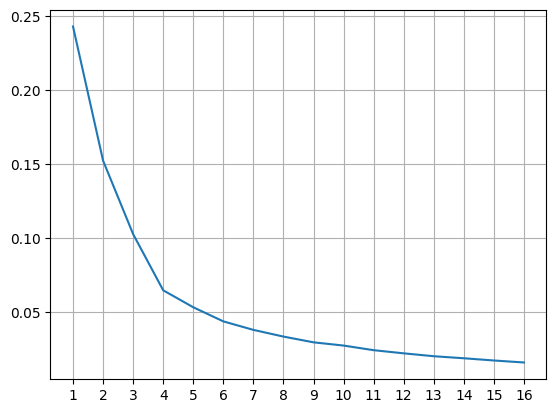

In [124]:
plt.plot(df_wcss.index, wcss)
plt.xticks(df_wcss.index)
plt.grid(True)

If we compress our restaurants into 1 clusters...
The Kmeans inertia is equal to 0.243
------------------------------------------------------------------------------------------------------------------------


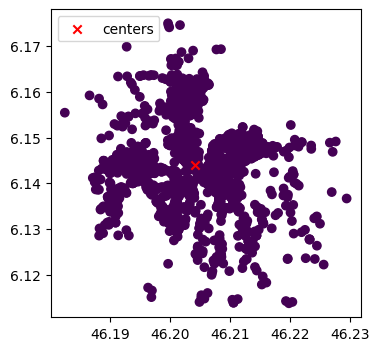

If we compress our restaurants into 2 clusters...
The Kmeans inertia is equal to 0.152
------------------------------------------------------------------------------------------------------------------------


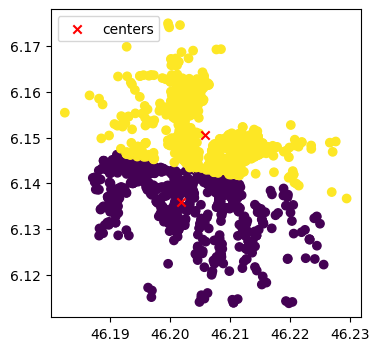

If we compress our restaurants into 3 clusters...
The Kmeans inertia is equal to 0.103
------------------------------------------------------------------------------------------------------------------------


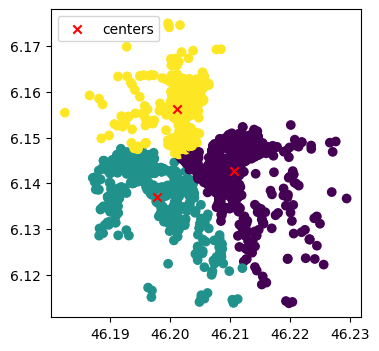

If we compress our restaurants into 4 clusters...
The Kmeans inertia is equal to 0.065
------------------------------------------------------------------------------------------------------------------------


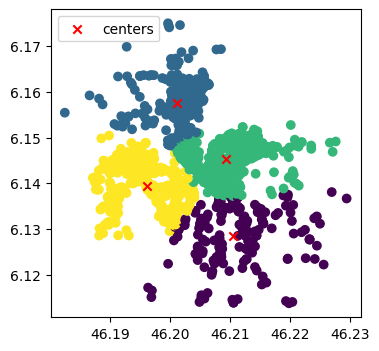

If we compress our restaurants into 5 clusters...
The Kmeans inertia is equal to 0.053
------------------------------------------------------------------------------------------------------------------------


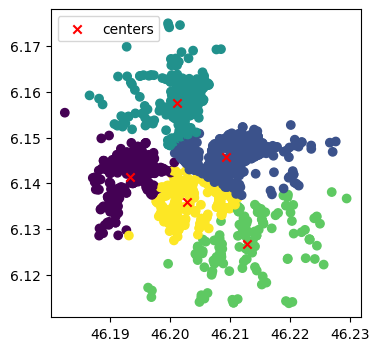

If we compress our restaurants into 6 clusters...
The Kmeans inertia is equal to 0.044
------------------------------------------------------------------------------------------------------------------------


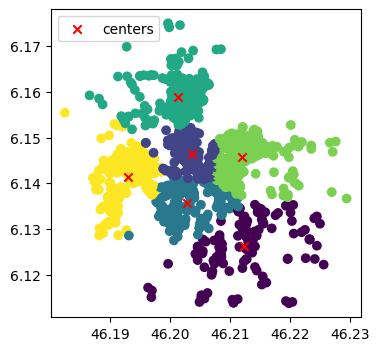

If we compress our restaurants into 7 clusters...
The Kmeans inertia is equal to 0.038
------------------------------------------------------------------------------------------------------------------------


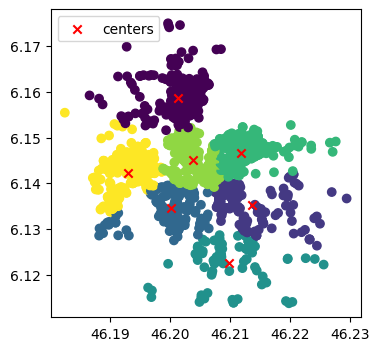

If we compress our restaurants into 8 clusters...
The Kmeans inertia is equal to 0.034
------------------------------------------------------------------------------------------------------------------------


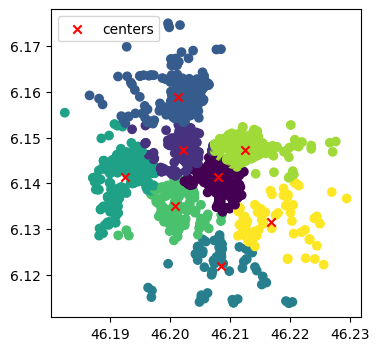

If we compress our restaurants into 9 clusters...
The Kmeans inertia is equal to 0.030
------------------------------------------------------------------------------------------------------------------------


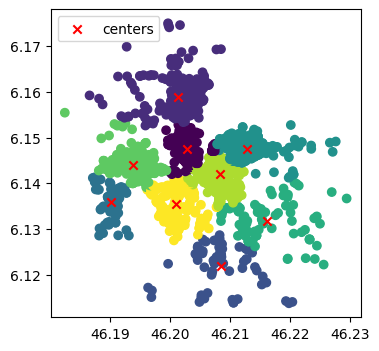

If we compress our restaurants into 10 clusters...
The Kmeans inertia is equal to 0.027
------------------------------------------------------------------------------------------------------------------------


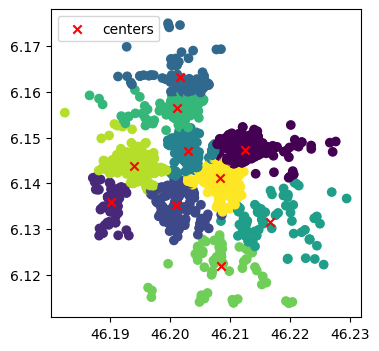

If we compress our restaurants into 11 clusters...
The Kmeans inertia is equal to 0.025
------------------------------------------------------------------------------------------------------------------------


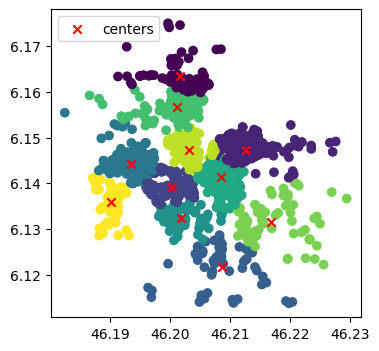

If we compress our restaurants into 12 clusters...
The Kmeans inertia is equal to 0.022
------------------------------------------------------------------------------------------------------------------------


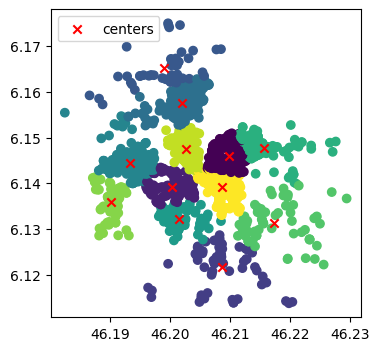

If we compress our restaurants into 13 clusters...
The Kmeans inertia is equal to 0.020
------------------------------------------------------------------------------------------------------------------------


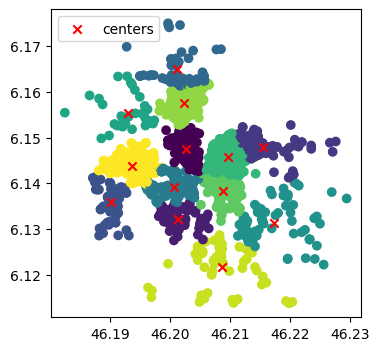

If we compress our restaurants into 14 clusters...
The Kmeans inertia is equal to 0.019
------------------------------------------------------------------------------------------------------------------------


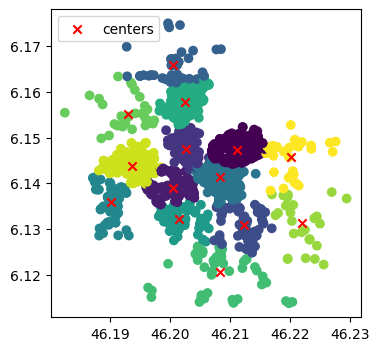

If we compress our restaurants into 15 clusters...
The Kmeans inertia is equal to 0.018
------------------------------------------------------------------------------------------------------------------------


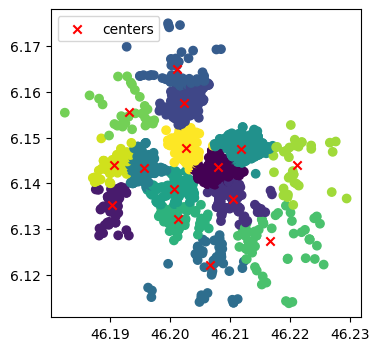

If we compress our restaurants into 16 clusters...
The Kmeans inertia is equal to 0.016
------------------------------------------------------------------------------------------------------------------------


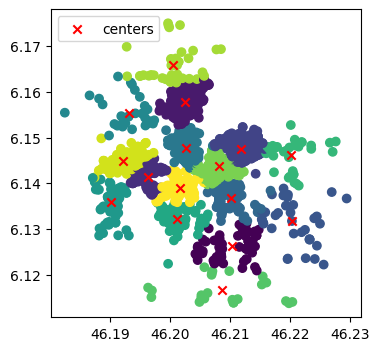

In [208]:
# let's continue to illustrate different clusters
X = rest_grid_points

wcss = []
clusters = list(range(1, 17))

for cluster in clusters:
    kmeans = KMeans(n_clusters =cluster, max_iter=100)
    kmeans.fit(X)
    
    # compute inertia
    wcss.append(kmeans.inertia_)
    
    # predict labels
    y_pred = kmeans.labels_
    
    # illustrate restaurant clusters
    print(f"If we compress our restaurants into {cluster} clusters...")
    print(f"The Kmeans inertia is equal to {kmeans.inertia_:.3f}")
    print("-"*120)
    plt.figure(figsize=(4,4))
    plt.scatter(X[:,0],X[:,1], c=y_pred)
    plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c='r', marker='x', label='centers')
    plt.legend(loc='upper left')
    plt.show()

## Silhouette Analysis

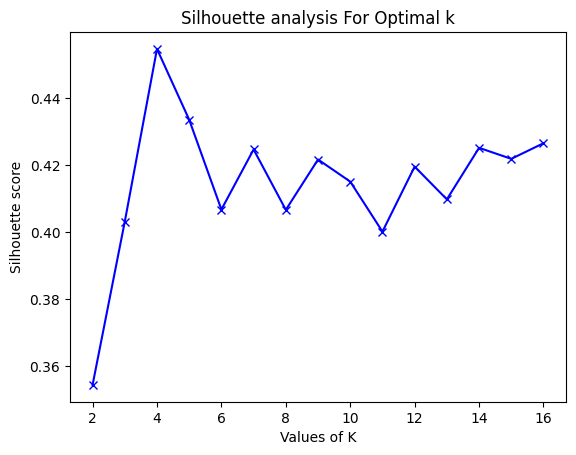

In [220]:
# let's continue to illustrate different clusters
X = rest_grid_points
silhouette_avg = []
clusters = list(range(2, 17))

for cluster in clusters:
    kmeans = KMeans(n_clusters=cluster, max_iter=100)
    kmeans.fit(X)
    
    # predict labels
    y_pred = kmeans.labels_

    # silhouette score
    silhouette_avg.append(silhouette_score(X, y_pred))

plt.plot(clusters,silhouette_avg,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

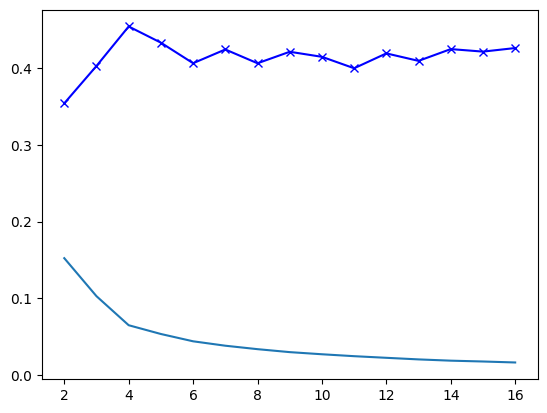

In [231]:
plt.plot(df_wcss.iloc[1:].index, wcss[1:])
plt.plot(clusters,silhouette_avg,'bx-')

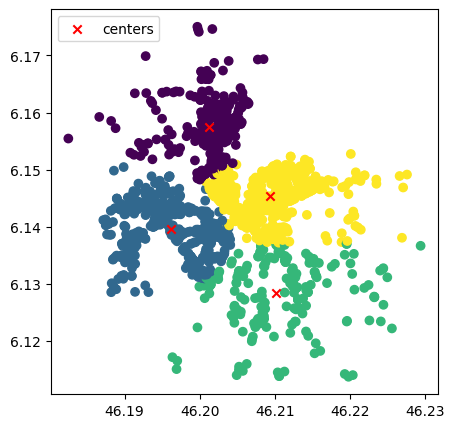

In [9]:
# Using 6 clusters

# let's start with a baseline of 4 arbitrary, just by looking at the graph
X = rest_grid_points
random_state = 42 #important to have reproducable kmeans algorithm

# Instanciate the model
km_final = KMeans(n_clusters=4, random_state=random_state)

# fit kmeans on grid_points
km_final.fit(X)

# make a prediction
y_pred_final = pd.Series(km_final.labels_)
y_pred_final

plt.figure(figsize=(5,5))
plt.scatter(X[:,0],X[:,1], c=y_pred_final)
plt.scatter(km_final.cluster_centers_[:,0], km_final.cluster_centers_[:,1], c='r', marker='x', label='centers')
plt.legend(loc='upper left')
plt.show()

In [7]:
df_rest['cluster'] = y_pred_final
df_rest.head()

place_id  tripadvisor_id                    fsq_id  \
0  ChIJd6kh67ZkjEcRC1IQourQOyo       7159041.0  4de685281f6e9d90c7f5325c   
1  ChIJX68uubZkjEcRKKxpZ7OrgqU      13322506.0                       NaN   
2  ChIJPcYsG_BljEcR4kTFqBJJoK4       6720272.0                       NaN   
3  ChIJhb4e-Ep7jEcRY38kziIGZmE             NaN                       NaN   
4  ChIJV8uySFxljEcRn7XpIO3zZX0             NaN                       NaN   

                              name business_status  \
0          Restaurant La Tentation     OPERATIONAL   
1            Café Restaurant Palma     OPERATIONAL   
2                    Le Versailles     OPERATIONAL   
3                 Restaurant Divan     OPERATIONAL   
4  Restaurant Les Jardins du Rhône     OPERATIONAL   

                                               types  price_level  \
0  ['restaurant', 'point_of_interest', 'food', 'e...          2.0   
1  ['restaurant', 'point_of_interest', 'food', 'e...          NaN   
2  ['restaurant', 'point_of_interest', 'food', 'e...          NaN   
3  ['restaurant', 'food', 'point_of_interest', 'e...          2.0   
4  ['restaurant', 'food', 'point_of_interest', 'e...          NaN   

   ta_price_level  rating  user_ratings_total  ...   population_15_19   \
0             2.0     4.2               158.0  ...                1547   
1             NaN     3.7               141.0  ...                1547   
2             2.0     3.9                56.0  ...                1547   
3             NaN     4.5               113.0  ...                1956   
4             NaN     NaN                 NaN  ...                1547   

    population_20_24    population_25_34    population_35_44   \
0                1937                5163                5549   
1                1937                5163                5549   
2                1937                5163                5549   
3                2148                4721                5127   
4                1937                5163                5549   

    population_45_54   population_54_64    population_65+   resident_per_km2   \
0                4924               4290              5625              16282   
1                4924               4290              5625              16282   
2                4924               4290              5625              16282   
3                5017               3956              5342               7187   
4                4924               4290              5625              16282   

   brut_income_annual_per_person  cluster  
0                          109266       2  
1                          109266       2  
2                          109266       2  
3                          123472       2  
4                          109266       2  

[5 rows x 45 columns]

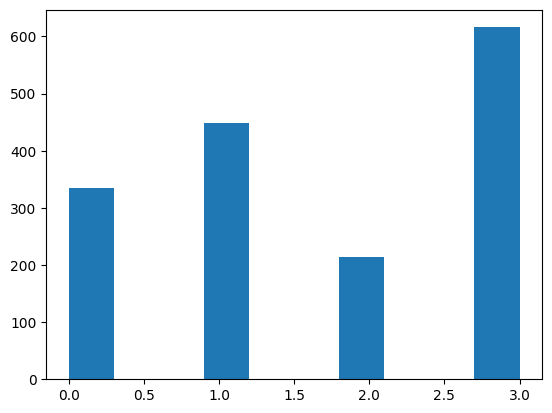

In [384]:
plt.hist(df_rest['cluster']);

In [385]:
km_final.cluster_centers_[y_pred_final]

array([[46.21012449,  6.12845119],
       [46.21012449,  6.12845119],
       [46.21012449,  6.12845119],
       ...,
       [46.20121188,  6.1574513 ],
       [46.20121188,  6.1574513 ],
       [46.20121188,  6.1574513 ]])

In [386]:
# squared distance to cluster center
X_dist = km_final.transform(X)**2
X_dist

array([[0.00182298, 0.00068775, 0.00020636, 0.0009397 ],
       [0.0019    , 0.00072868, 0.0002352 , 0.00099923],
       [0.00184286, 0.00070638, 0.00020647, 0.00094672],
       ...,
       [0.00029481, 0.00123838, 0.00223328, 0.0009468 ],
       [0.0003105 , 0.00126925, 0.00227621, 0.00097457],
       [0.00029478, 0.00125957, 0.00220212, 0.00091682]])

In [388]:
tmp = pd.DataFrame(X_dist.sum(axis=1).round(2), columns=['sqdist'])
tmp['label'] = y_pred_final
tmp

sqdist  label
0        0.0      2
1        0.0      2
2        0.0      2
3        0.0      2
4        0.0      2
...      ...    ...
1608     0.0      0
1609     0.0      0
1610     0.0      0
1611     0.0      0
1612     0.0      0

[1613 rows x 2 columns]

In [389]:
center_dists = np.array([X_dist[i][x] for i,x in enumerate(y_pred_final)])

max_indices = []
for label in np.unique(km_final.labels_):
    X_label_indices = np.where(y_pred_final==label)[0]
    max_label_idx = X_label_indices[np.argmax(center_dists[y_pred_final==label])]
    max_indices.append(max_label_idx)

max_indices

[1378, 99, 351, 401]

In [390]:
df_rest.iloc[351]

place_id                                                 ChIJrcqVYPpkjEcRdQXb7R4jqIo
tripadvisor_id                                                            12909029.0
fsq_id                                                                           NaN
name                                                               La Vie des Champs
business_status                                                          OPERATIONAL
types                              ['restaurant', 'park', 'food', 'point_of_inter...
price_level                                                                      2.0
ta_price_level                                                                   2.0
rating                                                                           4.7
user_ratings_total                                                             168.0
ta_rating                                                                        4.0
ta_user_ratings_total                                            

In [391]:
rest_grid_points[351]

array([46.2294255,  6.1366652])

In [392]:
import geopy.distance

c0 = [km_final.cluster_centers_[0,0], km_final.cluster_centers_[1,0]]
c1 = [46.229425, 6.136665]

rad = geopy.distance.geodesic(c0, c1).km
rad

3057.5977604338464

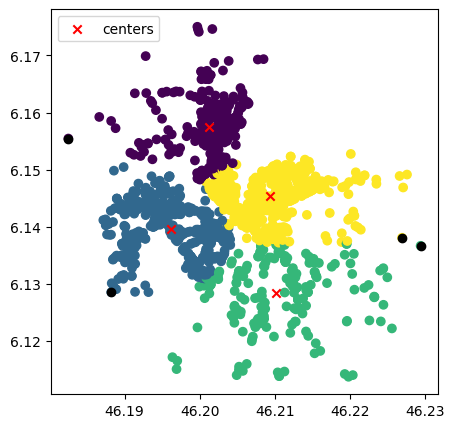

In [393]:
plt.figure(figsize=(5,5))
plt.scatter(X[:,0],X[:,1], c=y_pred_final)
plt.scatter(km_final.cluster_centers_[:,0], km_final.cluster_centers_[:,1], c='r', marker='x', label='centers')
plt.scatter(rest_grid_points[max_indices][:,0],rest_grid_points[max_indices][:,1],c='black')
plt.legend(loc='upper left')
plt.show()

In [364]:
df_rest[['cluster', 'zip_code']].groupby(['cluster', 'zip_code']).count()

Empty DataFrame
Columns: []
Index: [(0, 1201), (0, 1204), (0, 1205), (0, 1206), (0, 1207), (0, 1208), (0, 1214), (0, 1224), (1, 1201), (1, 1204), (1, 1205), (1, 1206), (1, 1227), (2, 1201), (2, 1202), (2, 1203), (2, 1205), (2, 1209), (2, 1213), (2, 1216), (2, 1219), (3, 1201), (3, 1202), (3, 1203), (3, 1204), (3, 1205), (3, 1207), (3, 1224), (3, 1292)]

In [10]:
import plotly.express as px

px.set_mapbox_access_token(open("../.env/.mapbox_access_token").read())
df = df_rest
fig = px.scatter_mapbox(df, lat="geometry.location.lat", 
                        lon="geometry.location.lng", 
                        color="cluster", 
                        size_max=15, 
                        zoom=10)
fig.show()

In [ ]:
px.set_mapbox_access_token(open("../.env/.mapbox_access_token").read())
df = df_rest
fig = px.scatter_mapbox(df, lat="geometry.location.lat", 
                        lon="geometry.location.lng", 
                        color="cluster", 
                        size_max=15, 
                        zoom=10)
fig.show()

In [5]:
px.set_mapbox_access_token(open("../.env/.mapbox_access_token").read())
df_base = df_rest
df_base['cluster'] = y_pred_base
fig = px.scatter_mapbox(df, lat="geometry.location.lat", 
                        lon="geometry.location.lng", 
                        color="cluster", 
                        size_max=15, 
                        zoom=10)
fig.show()

NameError: name 'df_rest' is not defined

# Clustering after Districts

In [8]:
df_rest_dist = pd.read_csv('../data/data_combined_v1.02.csv')
df_rest_dist.head()

place_id  tripadvisor_id                    fsq_id  \
0  ChIJd6kh67ZkjEcRC1IQourQOyo       7159041.0  4de685281f6e9d90c7f5325c   
1  ChIJX68uubZkjEcRKKxpZ7OrgqU      13322506.0                       NaN   
2  ChIJPcYsG_BljEcR4kTFqBJJoK4       6720272.0                       NaN   
3  ChIJV8uySFxljEcRn7XpIO3zZX0             NaN                       NaN   
4  ChIJW8zU8rZkjEcR_Ke8t7c7hVc             NaN                       NaN   

                                       name business_status  \
0                   Restaurant La Tentation     OPERATIONAL   
1                     Café Restaurant Palma     OPERATIONAL   
2                             Le Versailles     OPERATIONAL   
3           Restaurant Les Jardins du Rhône     OPERATIONAL   
4  Canteen De La Residence Gardens Du Rhône     OPERATIONAL   

                                               types  price_level  \
0  ['restaurant', 'point_of_interest', 'food', 'e...          2.0   
1  ['restaurant', 'point_of_interest', 'food', 'e...          NaN   
2  ['restaurant', 'point_of_interest', 'food', 'e...          NaN   
3  ['restaurant', 'food', 'point_of_interest', 'e...          NaN   
4  ['restaurant', 'food', 'point_of_interest', 'e...          NaN   

   ta_price_level  price_level_combined  rating  ...  population_20_24  \
0             2.0                   3.0     4.2  ...              1937   
1             NaN                   4.0     3.7  ...              1937   
2             2.0                   3.0     3.9  ...              1937   
3             NaN                   NaN     NaN  ...              1937   
4             NaN                   4.0     5.0  ...              1937   

   population_25_34  population_35_44  population_45_54  population_54_64  \
0              5163              5549              4924              4290   
1              5163              5549              4924              4290   
2              5163              5549              4924              4290   
3              5163              5549              4924              4290   
4              5163              5549              4924              4290   

   population_65+ resident_per_km2  brut_income_annual_per_person cluster  \
0            5625            16282                         109266       2   
1            5625            16282                         109266       2   
2            5625            16282                         109266       2   
3            5625            16282                         109266       2   
4            5625            16282                         109266       2   

                district  
0  Saint-Jean Charmilles  
1  Saint-Jean Charmilles  
2  Saint-Jean Charmilles  
3  Saint-Jean Charmilles  
4  Saint-Jean Charmilles  

[5 rows x 47 columns]

In [32]:
px.set_mapbox_access_token(open("../.env/.mapbox_access_token").read())
df = df_rest_dist
fig = px.scatter_mapbox(df, lat="geometry.location.lat", 
                        lon="geometry.location.lng", 
                        color="district",
                        opacity=0.5,
                        center={'lat':46.2043907,'lon':6.1431577},
                        width=800,
                        height=600,
                        zoom=12)
fig.show()